# Bibliotecas 


In [35]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #instalando Pytorch com suporte a GPU
#testando a instalacao 
#import torch
#print(torch.__version__)  # Deve exibir a versão do PyTorch instalada
#print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver funcionando
#print(torch.cuda.get_device_name())  # exibe sua placa de video


In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, balanced_accuracy_score, matthews_corrcoef, 
    f1_score, accuracy_score, roc_curve, auc, make_scorer
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.samplers import TPESampler
import logging
import warnings
from torch.optim import lr_scheduler
from joblib import Parallel, delayed
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier



########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################

# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


#  Análise Exploratória (EDA) & Data Prep

Primeiras linhas para primeiro contato com a base de dados 


In [37]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Dimensões, Tipos e checagem de missing values (nulos)

In [38]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])

Numero de linhas: 10000
Numero de colunas: 18


In [39]:
#tipos
base_original.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

In [40]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [54]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in base_original.columns:
    zero_count = (base_original[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

#nao foi constatao nada muito impactante, as variaveis com mais zero sao categoriacas (binarias) 
# Balance seria a unica a se preocupar, mas vamos manter. 



 'RowNumber': 0 valores zero

 'CustomerId': 0 valores zero

 'Surname': 0 valores zero

 'CreditScore': 0 valores zero

 'Geography': 0 valores zero

 'Gender': 0 valores zero

 'Age': 0 valores zero

 'Tenure': 413 valores zero

 'Balance': 3617 valores zero

 'NumOfProducts': 0 valores zero

 'HasCrCard': 2945 valores zero

 'IsActiveMember': 4849 valores zero

 'EstimatedSalary': 0 valores zero

 'Exited': 7962 valores zero

 'Complain': 7956 valores zero

 'Satisfaction Score': 0 valores zero

 'Card Type': 0 valores zero

 'Point Earned': 0 valores zero


* Limpando variaveis inuteis para analise
* Resumo estatistico de veriaveis quantitativas


In [41]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname 

#removida Gender por poder inviesar o modelo de alguma formna descriminativa, é uma boa pratica de LGPD nao usar dados sensiveis como esse etc. 

df = base_original[['CreditScore',
                    #'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,"10.000,0","10.000,0","10.000,0","10.000,0","10.000,0","10.000,0"
mean,"100.090,2","76.485,9","650,5","38,9","5,0","606,5"
std,"57.510,5","62.397,4","96,7","10,5","2,9","225,9"
min,"11,6","0,0","350,0","18,0","0,0","119,0"
25%,"51.002,1","0,0","584,0","32,0","3,0","410,0"
50%,"100.193,9","97.198,5","652,0","37,0","5,0","605,0"
75%,"149.388,2","127.644,2","718,0","44,0","7,0","801,0"
max,"199.992,5","250.898,1","850,0","92,0","10,0","1.000,0"


* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


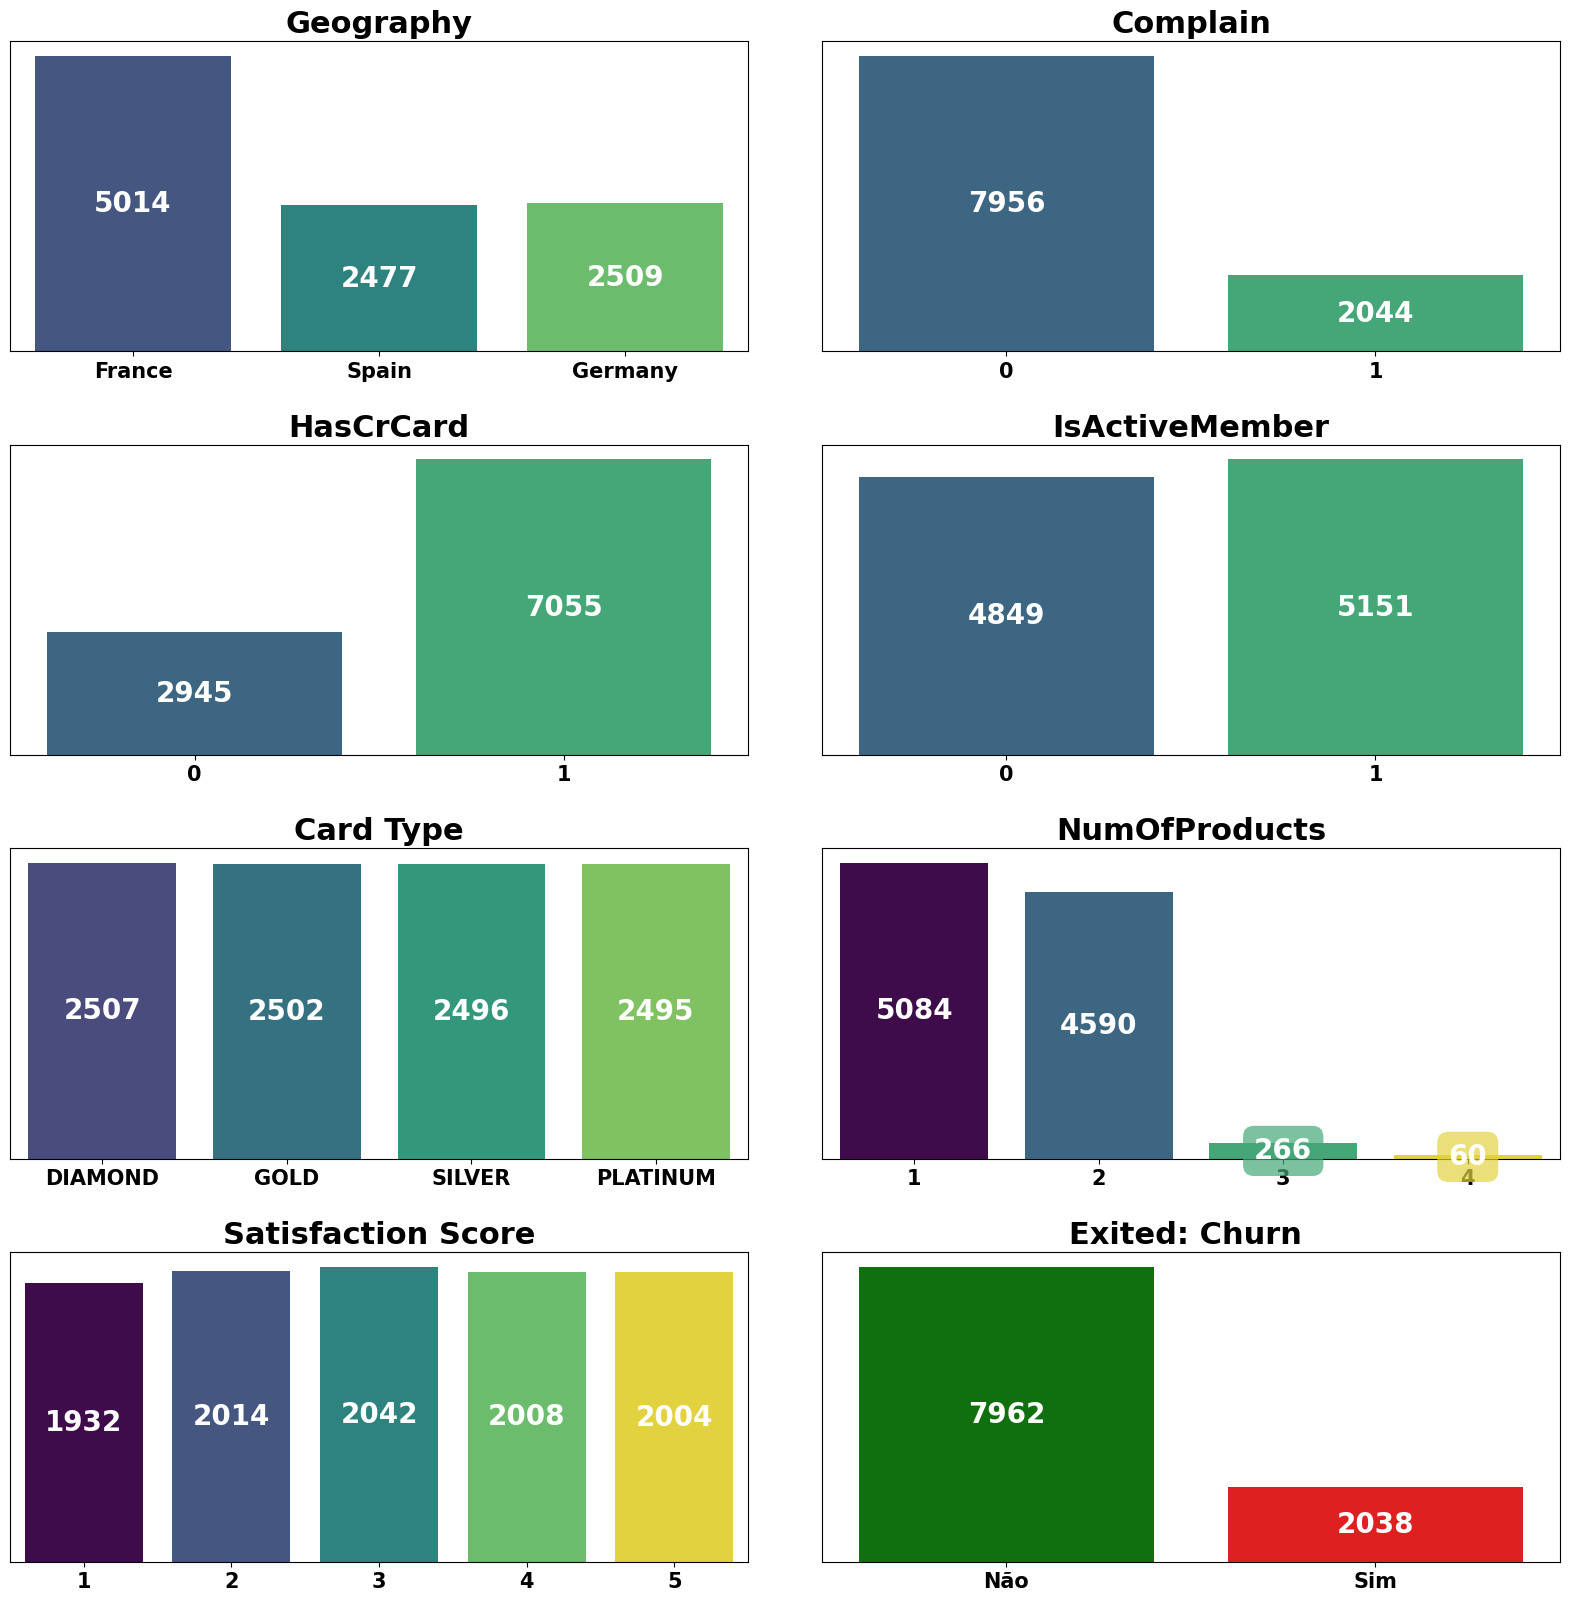

In [42]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 'IsActiveMember', 'Geography',
            #'Gender',
             'Complain','Exited','Card Type','NumOfProducts','Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)


# Complain
plt.subplot(5, 2, 2)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 3)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 4)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 5)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 7)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



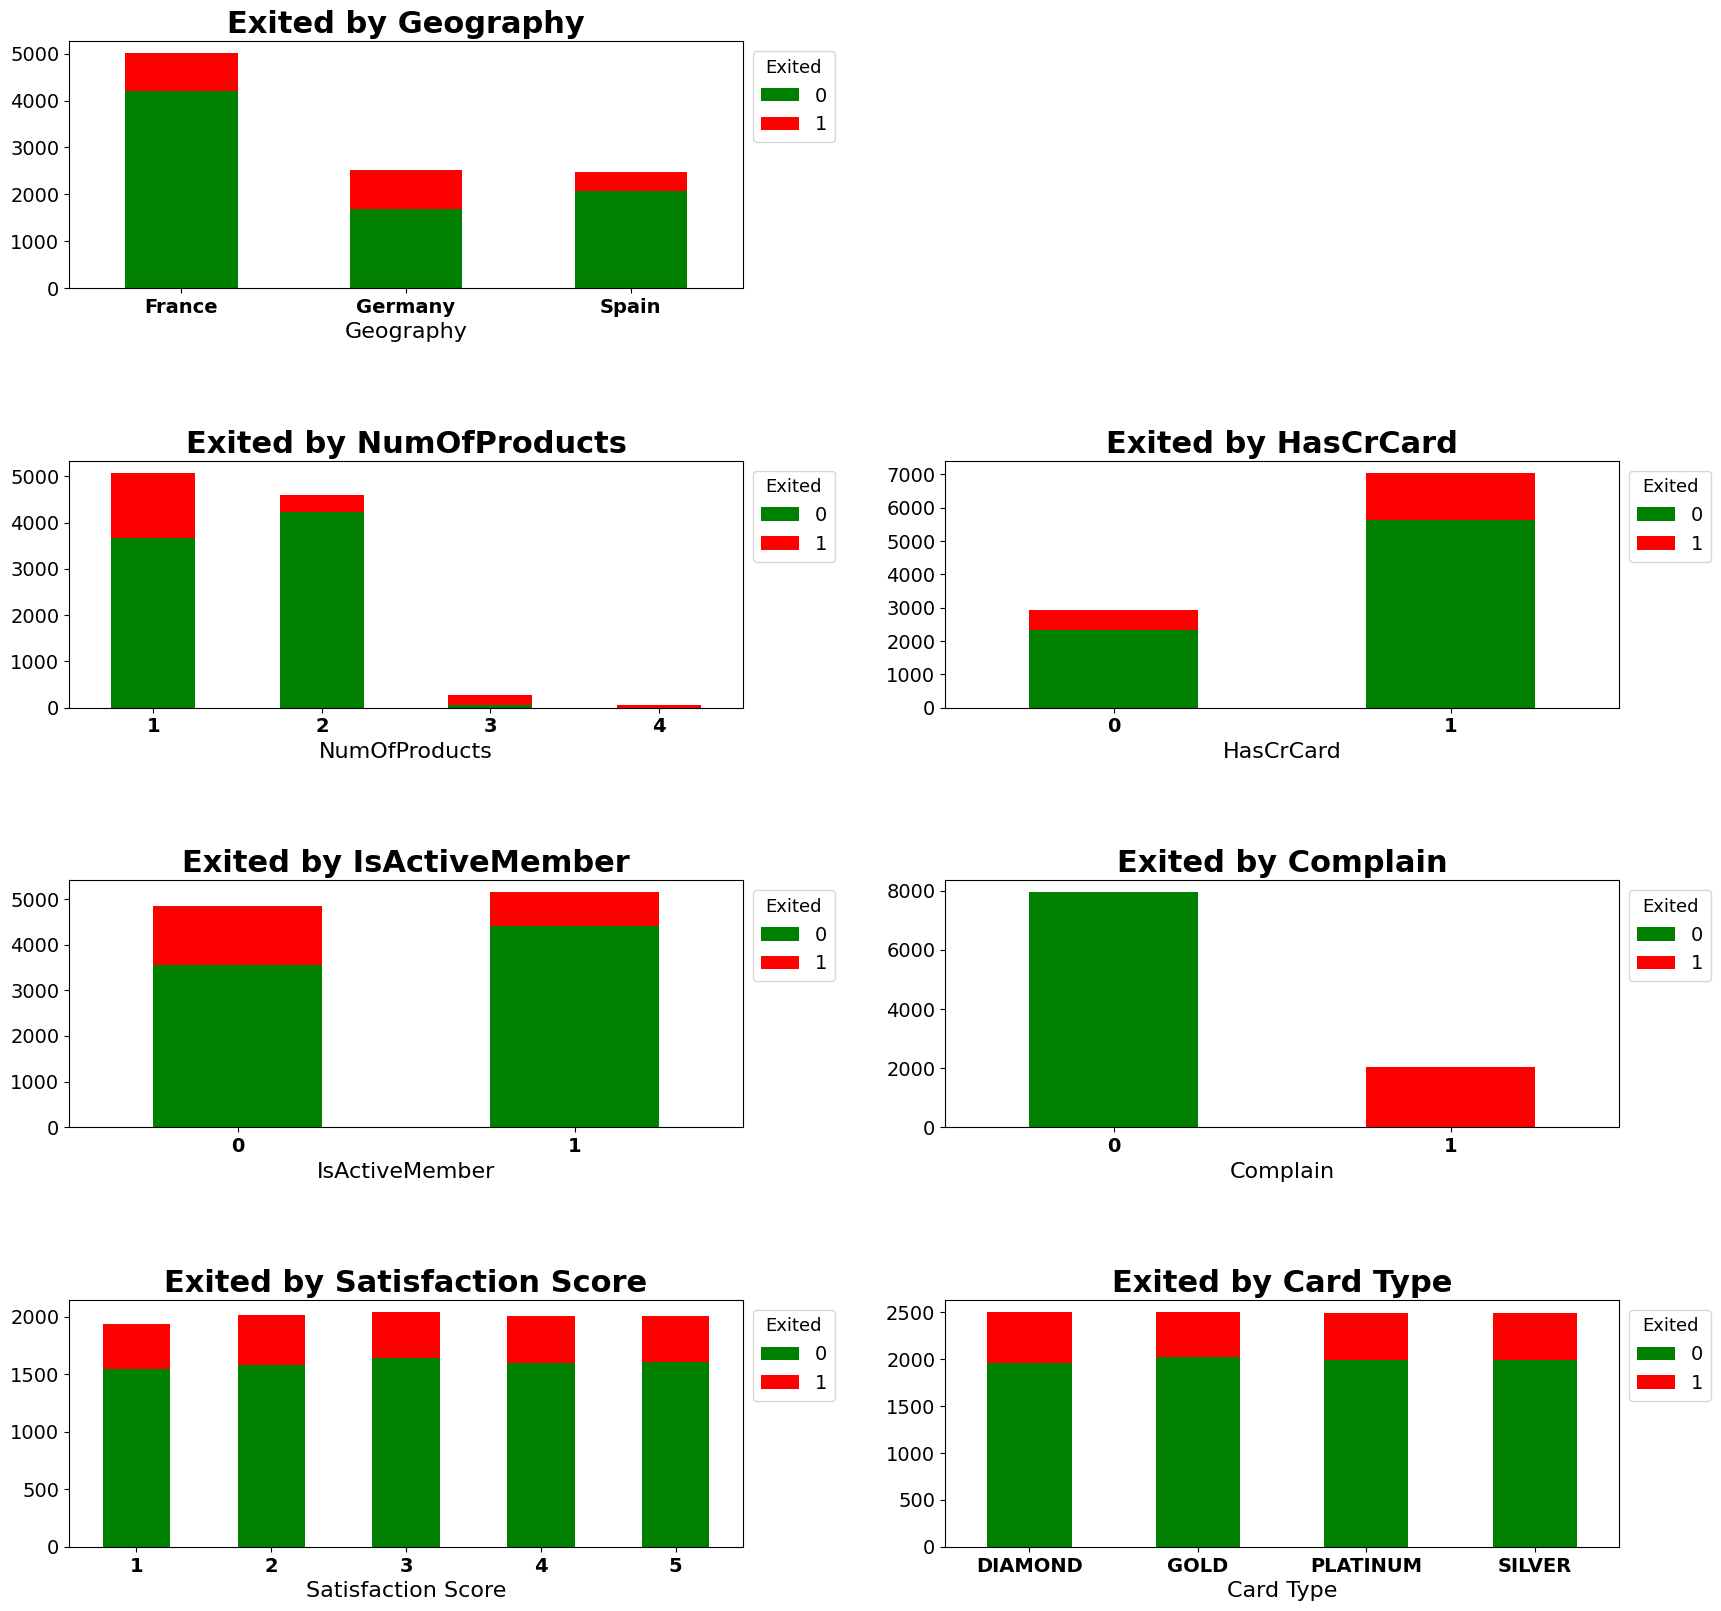

In [43]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)


# NumOfProducts
plt.subplot(5, 2, 3)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 4)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 5)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 8)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo MLP (Multilayer Perceptron) e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 

* foi necessario aplicar Ordinal-Encoder. 
 
 

In [44]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean)
warnings.filterwarnings('ignore', category=FutureWarning)

# Lista de variáveis a serem transformadas
cols_to_transform = ['Geography']

# Convertendo para string (somente a coluna "Geography")
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# Realizando o One-Hot Encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)

# Ordinal-Encoder 
df_dummies['Card Type'] = OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]], dtype=int).fit_transform(df_dummies[['Card Type']])

# Variável alvo 'Exited' para o tipo numérico (se necessário)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)


CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Card Type               int32
Point Earned            int64
Exited                  int64
Geography_France        int32
Geography_Germany       int32
Geography_Spain         int32
dtype: object


# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso MLPs capturam naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


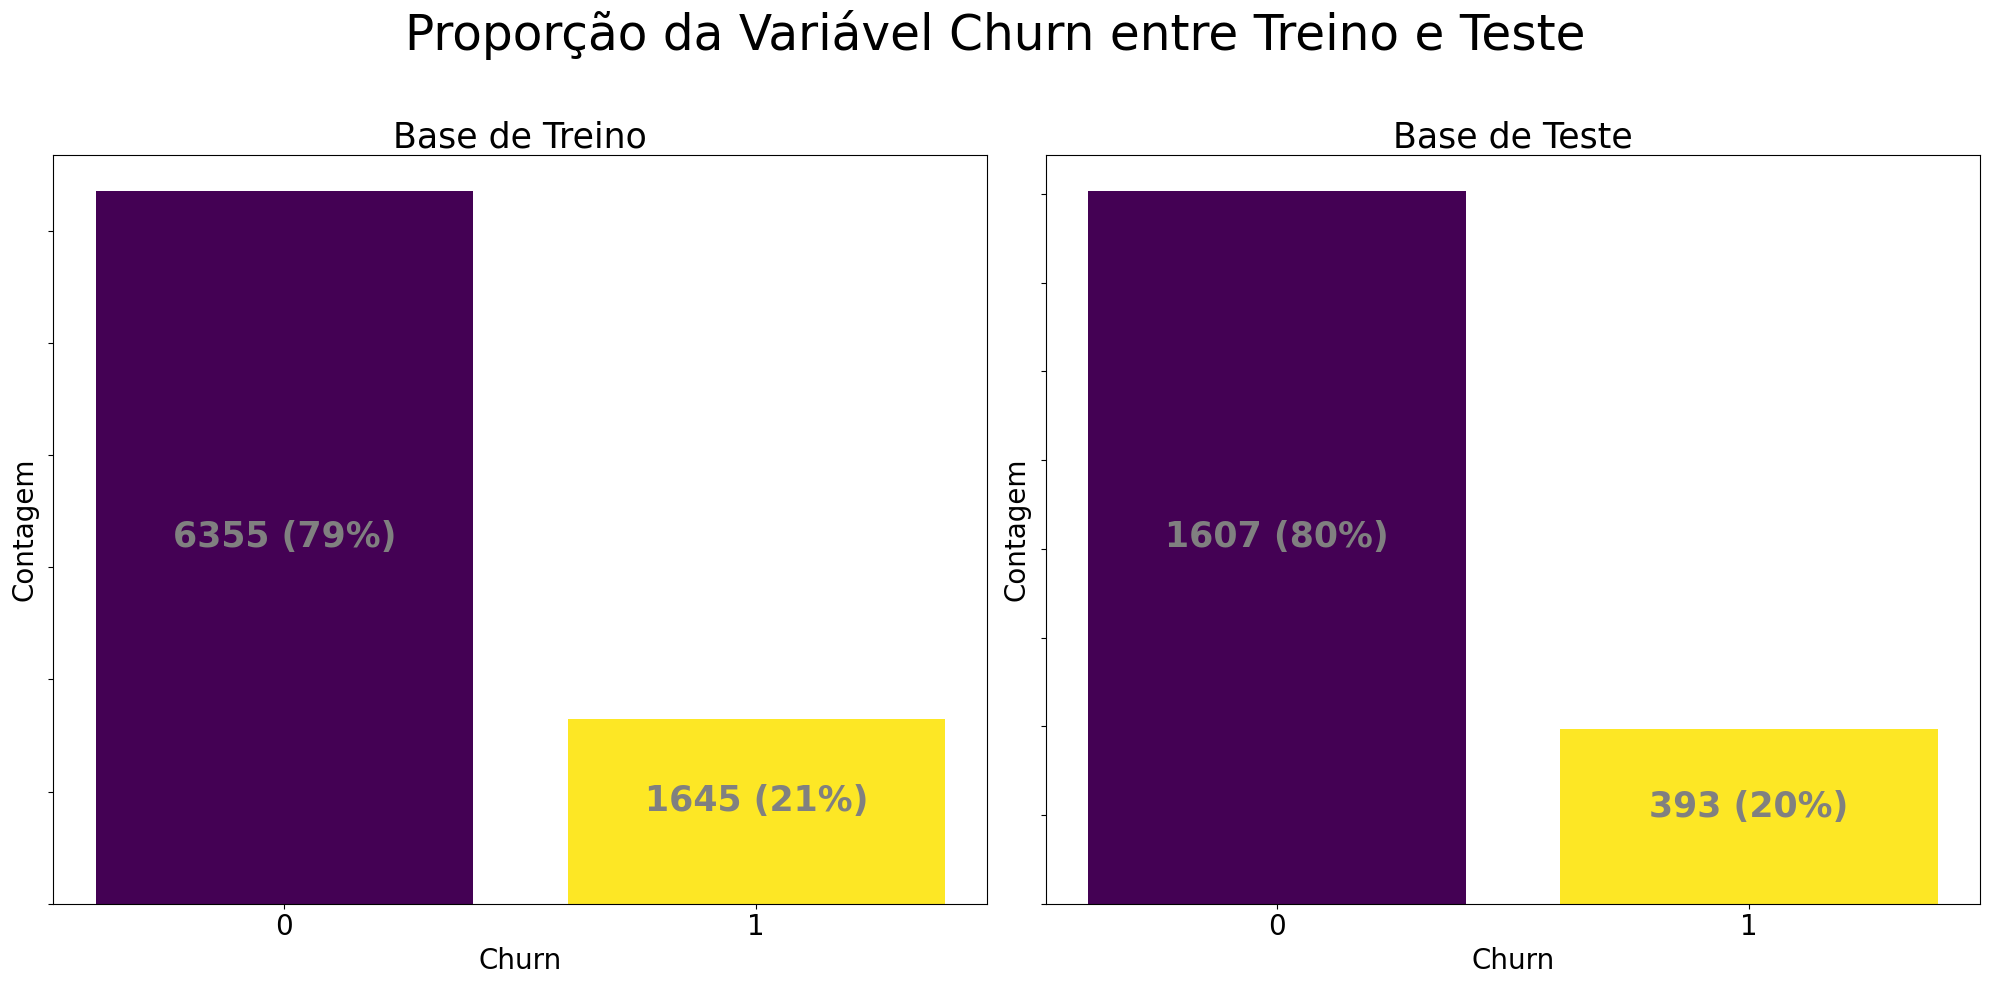

In [45]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain'])


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da MLP (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



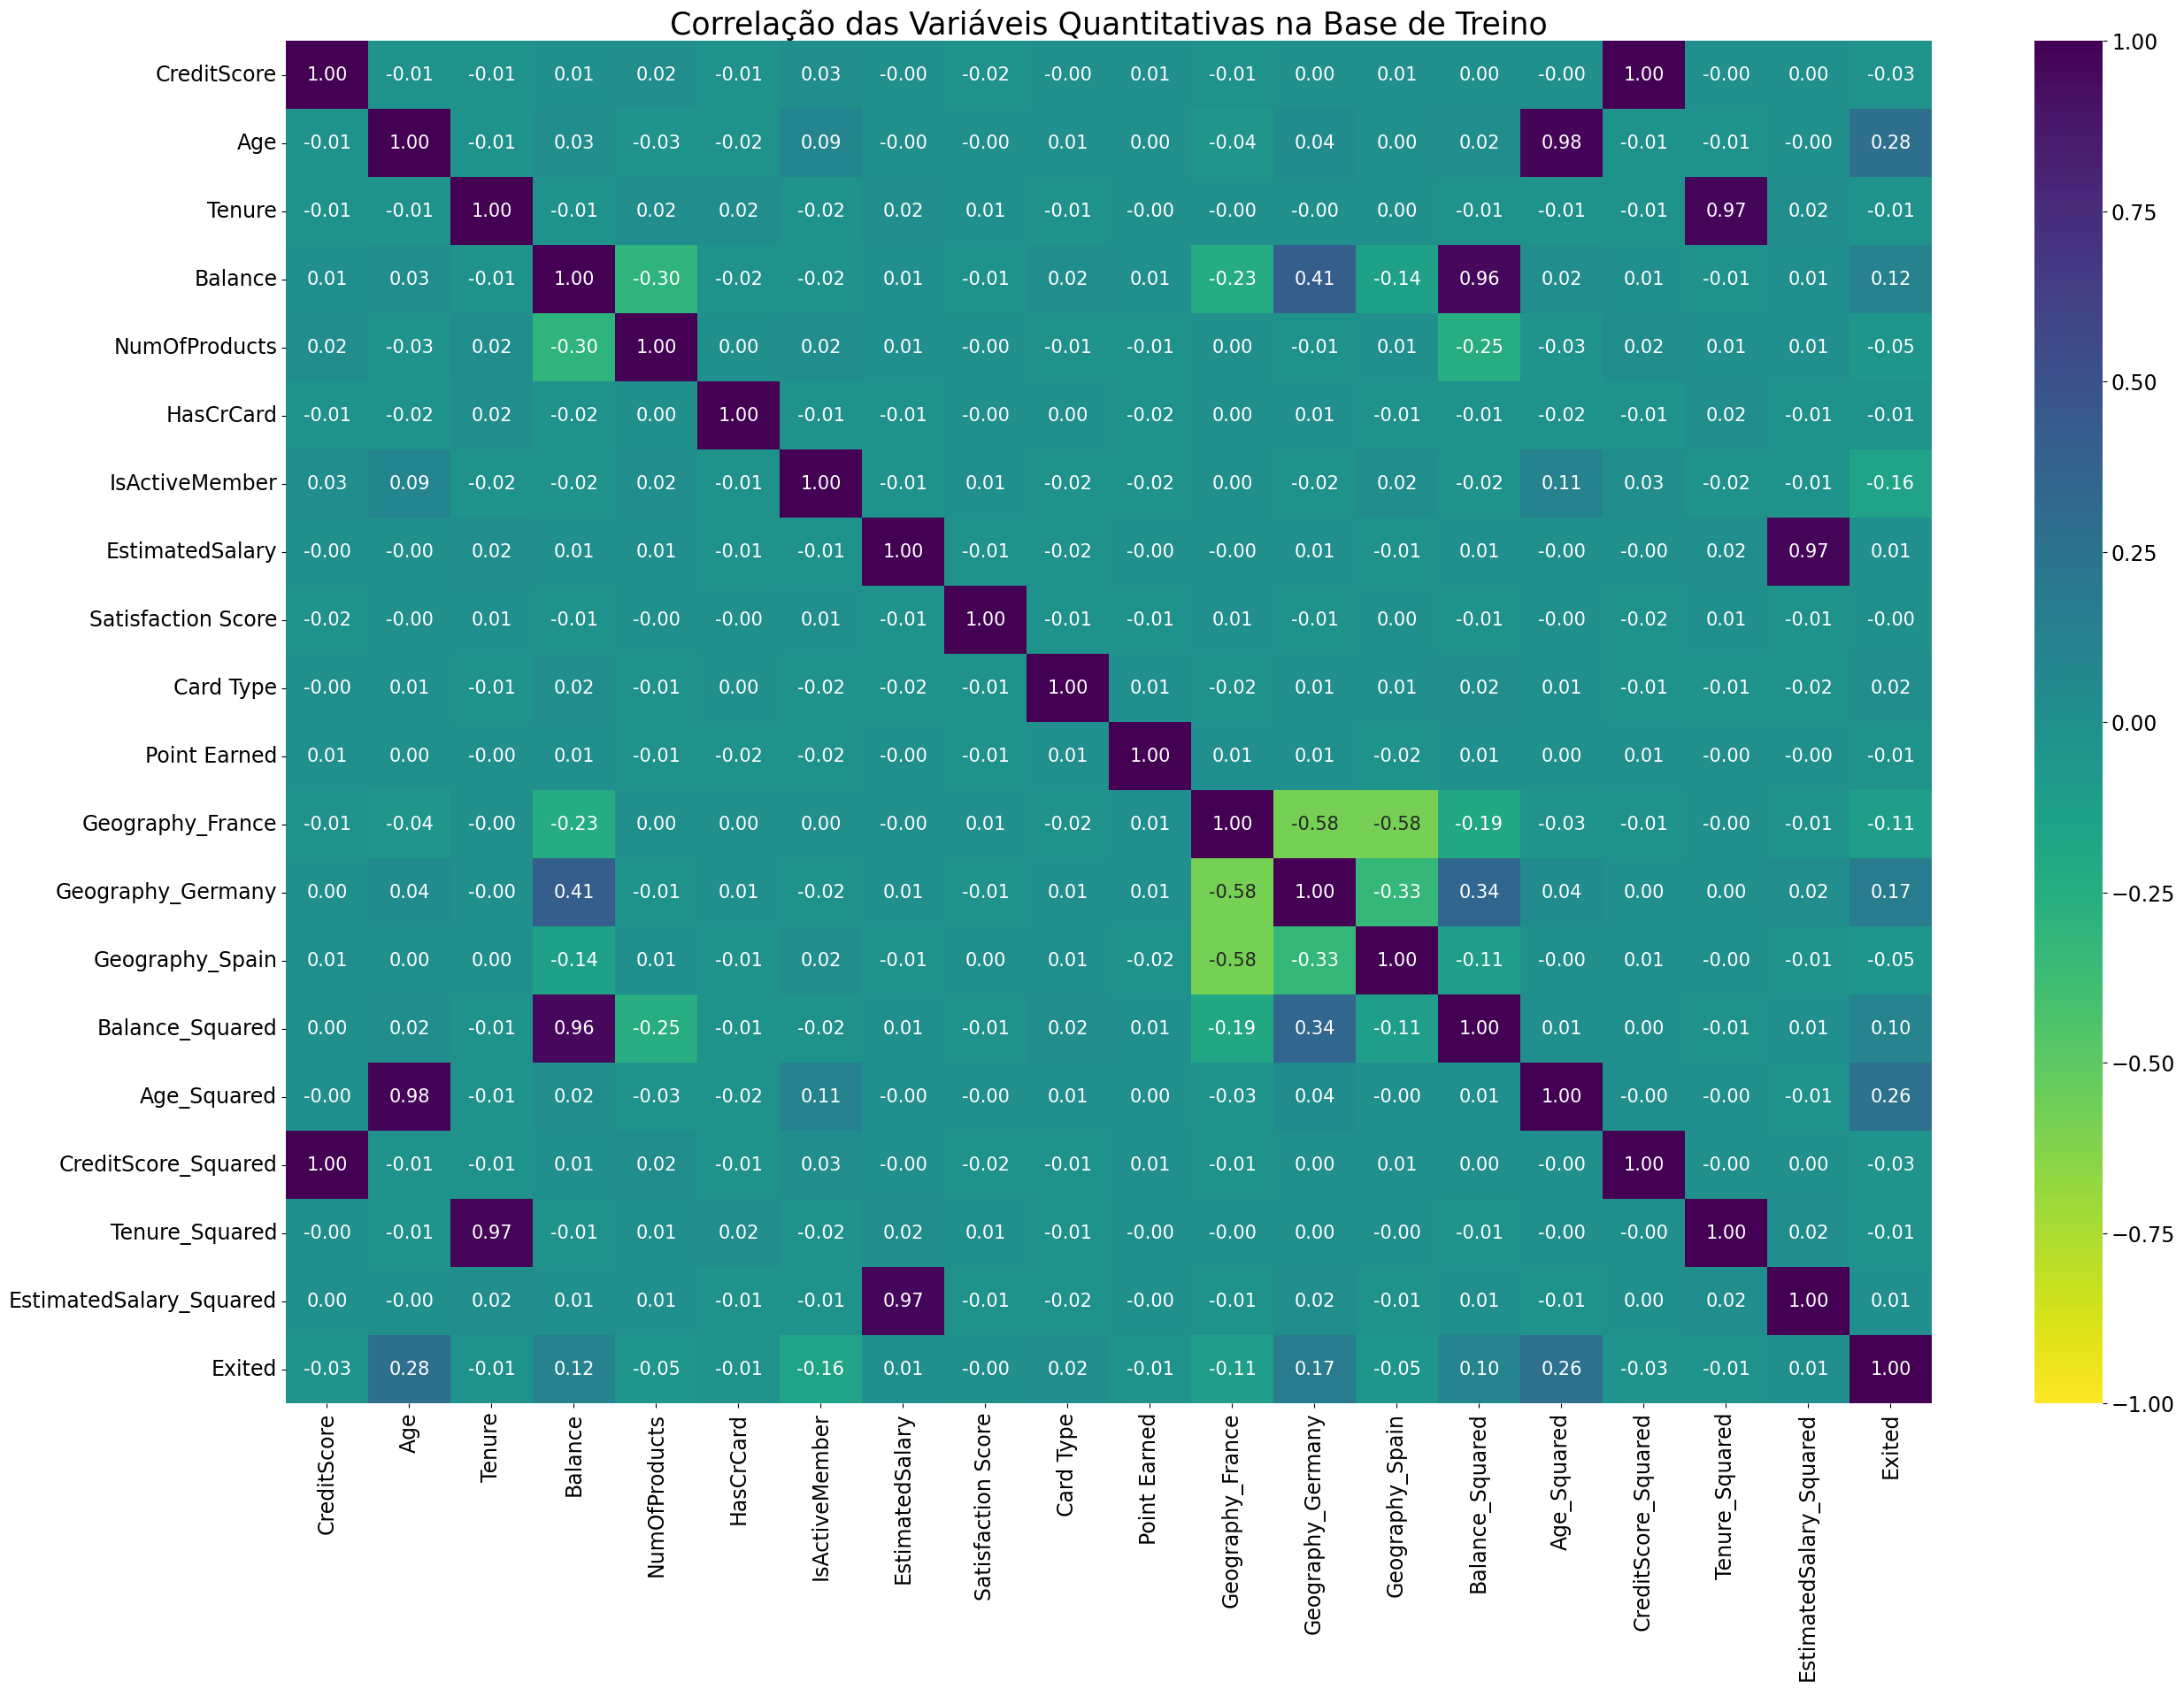

In [46]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos de MLP porque eles utilizam backpropagation e descida do gradiente, entre outras coisas que podem atrapalhar a capacidade preditiva do modelo; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

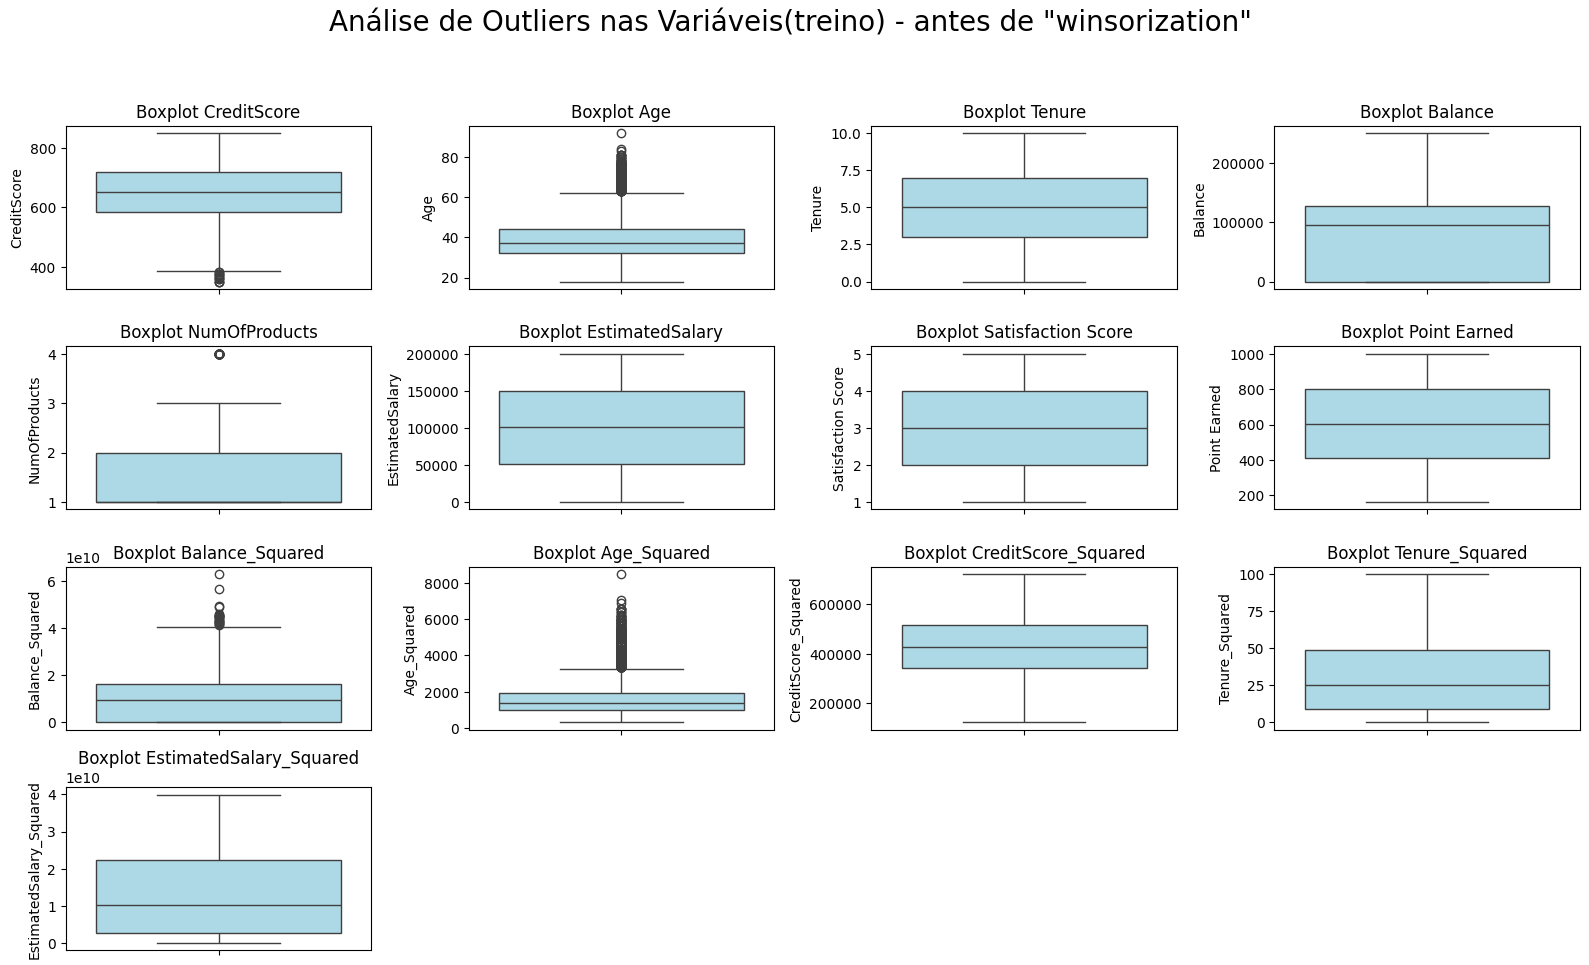

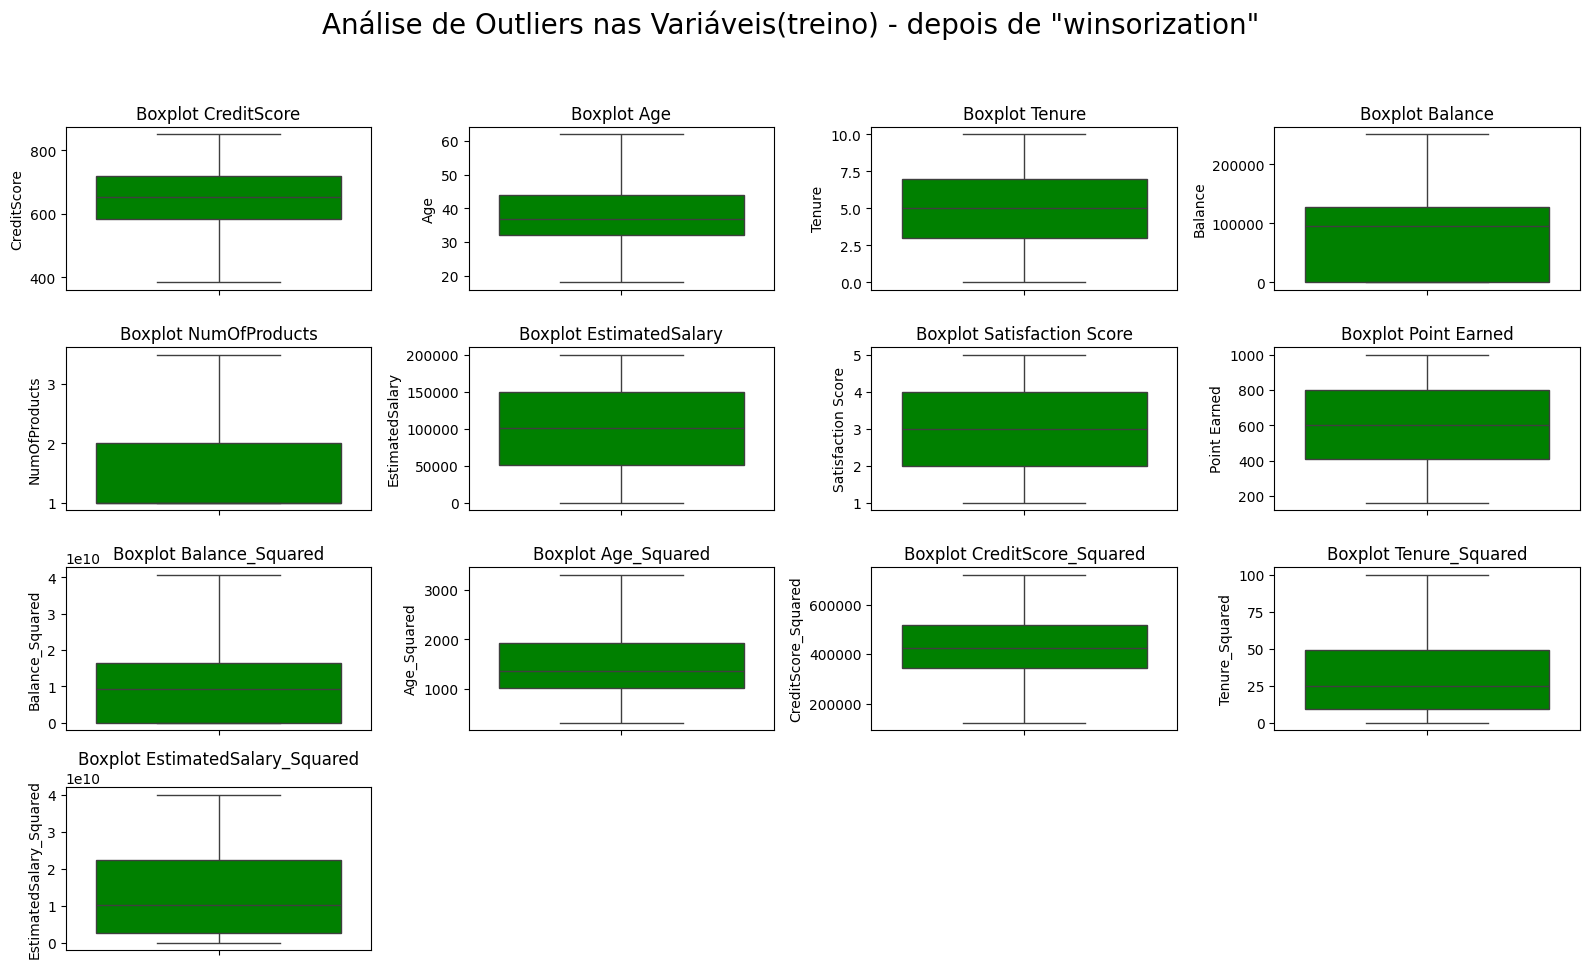

In [47]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

* verificando as bases de treino e teste uma ultima vez para garantir que estao corretas 


In [48]:
#BASE DE TREINO 
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9254,686.0,32.0,6.0,0.00,2.0,1,1,179093.26,2.0,3,510.0,1,0,0,0.000000e+00,1024.0,470596.0,36.0,3.207440e+10,0
1561,632.0,42.0,4.0,119624.60,2.0,1,1,195978.86,4.0,2,959.0,0,1,0,1.431004e+10,1764.0,399424.0,16.0,3.840771e+10,0
1670,559.0,24.0,3.0,114739.92,1.0,1,0,85891.02,4.0,0,327.0,0,0,1,1.316525e+10,576.0,312481.0,9.0,7.377267e+09,1
6087,561.0,27.0,9.0,135637.00,1.0,1,0,153080.40,2.0,0,567.0,1,0,0,1.839740e+10,729.0,314721.0,81.0,2.343361e+10,1
6669,517.0,56.0,9.0,142147.32,1.0,0,0,39488.04,3.0,2,727.0,1,0,0,2.020586e+10,3136.0,267289.0,81.0,1.559305e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8.0,69712.74,1.0,1,1,69381.05,3.0,0,569.0,1,0,0,4.859866e+09,2916.0,589824.0,64.0,4.813730e+09,0
5191,682.0,58.0,1.0,0.00,1.0,1,1,706.50,4.0,2,709.0,1,0,0,0.000000e+00,3304.0,465124.0,1.0,4.991422e+05,0
5390,735.0,38.0,1.0,0.00,3.0,0,0,92220.12,5.0,0,678.0,1,0,0,0.000000e+00,1444.0,540225.0,1.0,8.504551e+09,1
860,667.0,43.0,8.0,190227.46,1.0,1,0,97508.04,3.0,3,680.0,1,0,0,3.618649e+10,1849.0,444889.0,64.0,9.507818e+09,1


In [49]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Balance_Squared,Age_Squared,CreditScore_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,0,0,41788.37,1,1,709,0,1,0,9.352644e+09,1024,355216,9,1.746268e+09,0
4684,623,43,1,0.00,2,1,1,146379.30,2,0,508,1,0,0,0.000000e+00,1849,388129,1,2.142690e+10,0
1731,601,44,4,0.00,2,1,0,58561.31,1,1,281,0,0,1,0.000000e+00,1936,361201,16,3.429427e+09,0
4742,506,59,8,119152.10,2,1,1,170679.74,2,0,979,0,1,0,1.419722e+10,3481,256036,64,2.913157e+10,0
4521,560,27,7,124995.98,1,1,1,114669.79,5,0,457,0,0,1,1.562400e+10,729,313600,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,602,53,5,98268.84,1,0,1,45038.29,5,2,813,0,1,0,9.656765e+09,2809,362404,25,2.028448e+09,1
8285,609,25,10,0.00,1,0,1,109895.16,2,2,652,1,0,0,0.000000e+00,625,370881,100,1.207695e+10,0
7853,730,47,7,0.00,1,1,0,33373.26,2,2,504,1,0,0,0.000000e+00,2209,532900,49,1.113774e+09,1
1095,692,29,4,0.00,1,1,0,76755.99,3,2,686,1,0,0,0.000000e+00,841,478864,16,5.891482e+09,1


# Modelagem: aplicando MLP com Pytorch

* O PyTorch é uma biblioteca de aprendizado profundo de código aberto, usada principalmente para o treinamento de redes neurais artificiais. Ele oferece flexibilidade e eficiência, permitindo a criação de modelos complexos e o treinamento acelerado com GPUs. O PyTorch é popular entre os pesquisadores devido à sua abordagem dinâmica de construção de grafos computacionais, facilitando a experimentação.

* Para mais informações, você pode acessar a documentação oficial do PyTorch:
https://pytorch.org/docs/stable/


* Uma MLP (Multilayer Perceptron) é um tipo de rede neural artificial composta por múltiplas camadas de neurônios, usada principalmente para tarefas de classificação e regressão.


* **OBS: Para conseguir usar GPU com CUDA fora do kaggle é necessario verificar se sua placa de video suporta (da um google ai) caso suporte e esteja configurado, o codigo ira habilitar automaticamente. O codigo tambem executa em CPU, basta nao ativar a GPU (CUDA) que ele seleciona a CPU automaticamente. A primeira celula tem comentado um pouco de como ativei.** 


1️. **Pré-processamento e Preparação dos Dados:**
* definir X_train e y_train;

2️. **Seleção de Features com Random Forest:**
* Modelo Random Forest treinado para identificar variáveis mais relevantes;
* variaveis com importancia observada maior que 0.01 foram selecionadas para participarem do modelo;

3️. **Escalonamento dos Dados:**
* StandardScaler para normalizar as features selecionadas ( X_train e X_test);

4️. **Preparação para o Treinamento com PyTorch:**
* Configuração do dispositivo (GPU CUDA ou CPU);
* Conversão dos dados escalonados em tensores PyTorch;


------------------------
MLP - Multi-Layer Perceptron 
------------------------
------------------------
Início: 2025-03-11 03:34:23.902018
------------------------
Índices de X_test e y_test já estavam alinhados.


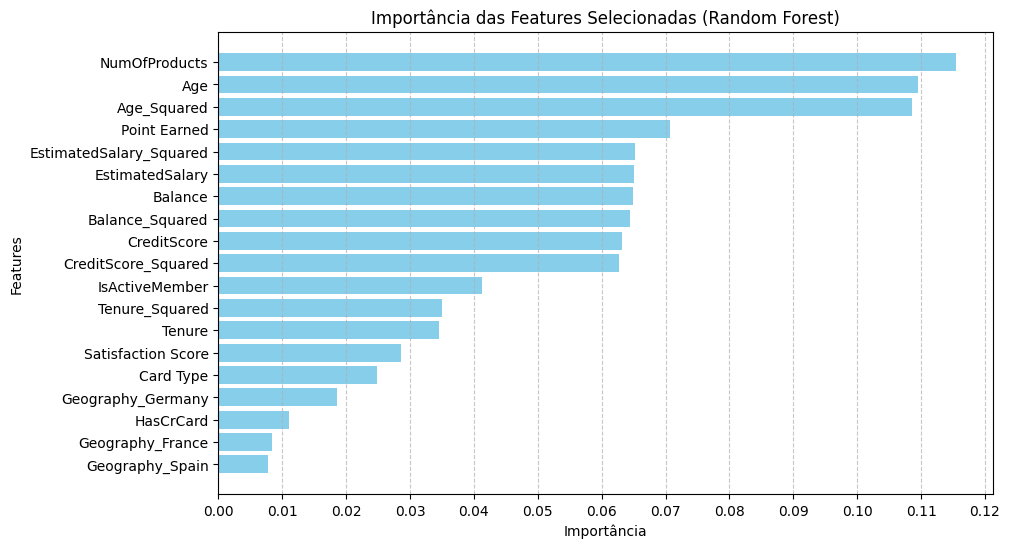

Dispositivo configurado: cuda


Processando tensores: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  6.15it/s]

X_train_tensor shape: torch.Size([8000, 17]) | device: cuda:0
y_train_tensor shape: torch.Size([8000]) | device: cuda:0
X_test_tensor shape: torch.Size([2000, 17]) | device: cuda:0
y_test_tensor shape: torch.Size([2000]) | device: cuda:0


In [50]:
print('------------------------')
print("MLP - Multi-Layer Perceptron ")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 


# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 

# Mais estavel que o mutual_info_classif e melhor que ANOVA
# (ele captura bem relacoes nao lineares e nao sofre variacoes como mutual_info)

#detalhe importante, nao tem predict(), somente o fit() 


rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()

# Aplicar a seleção das mesmas features ao conjunto de treino e teste
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


scaler = StandardScaler()

# Escalonar os dados de treino e teste selecionados
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Configurar dispositivo para PyTorch (verifica a disponibilidade de GPU, caso contrário, usa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA ou CPU
# device = torch.device("cpu")  # Forçar uso da CPU, se necessário

print("Dispositivo configurado:", device)


bar = tqdm(total=1, desc="Processando tensores", ncols=100, position=0) #barra de progresso plotada, ajuda a monitorar

# Convertendo para tensores PyTorch e movendo para o dispositivo
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)  

bar.update(1) #incrementa barra
bar.close()#fecha barra

# Verificando os shapes dos tensores depois de criados e dispositivo ativado em cada um, 
# para ter certeza da compatibilidade de processamento e tamanho
print(f"X_train_tensor shape: {X_train_tensor.shape} | device: {X_train_tensor.device}")
print(f"y_train_tensor shape: {y_train_tensor.shape} | device: {y_train_tensor.device}")
print(f"X_test_tensor shape: {X_test_tensor.shape} | device: {X_test_tensor.device}")
print(f"y_test_tensor shape: {y_test_tensor.shape} | device: {y_test_tensor.device}")

5. **Definição da Arquitetura do Modelo (MLP):**

* Configuração das camadas ocultas e da de saída;
* Aplicação de função de ativação selecionável (ReLU, Tanh, etc.); 
* Uso de Dropout para reduzir overfitting;
* Função de perda: BCEWithLogitsLoss com ponderação para classe minoritária; 
* Otimização: Suporte a vários otimizadores (Adam, SGD, etc.); 
* Agendador de taxa de aprendizado (StepLR, CosineAnnealing, ReduceLROnPlateau, etc.);
* Salvamento do melhor modelo para aproveitamento futuro (torch.save); 

6. **Otimização de Hiperparâmetros com Optuna:**

* Busca de hiperparâmetros usando Optuna (similar ao GridSearch, mas mais eficiente);
* Definição de hiperparâmetros para estudo do optuna: taxa de aprendizado, peso de regularização (alpha e weight_decay), dropout, número de épocas etc; 

7. **Validação Cruzada com Stratified K-Fold:** 

* Divisão dos dados em folds estratificados;
* Rebalanceamento da classe minoritária com ADASYN (oversampling adaptativo); 
* Uso de CUDA (GPU) para acelerar o treinamento;

8. **Métricas de Avaliação dentro do fluxo de melhoria:** 
* AUC-ROC: Avaliação da separabilidade entre classes;
* Recall: Importante para classificar corretamente a classe minoritária;
* F1-Score: Equilíbrio entre precisão e recall ( é calculado mas nao usado para otimizar, nao afetou muito coloca-la a principio).

In [ ]:
print('##########  MODELAGEM  ##################')

bar = tqdm(total=1, desc="Criando modelo", ncols=100, position=0)# Inicializando a barra de progresso


# classe MLP do modelo
class MLP(nn.Module):
    def __init__(self, hidden_layer_sizes, activation, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = X_train_tensor.shape[1]  
        for units in hidden_layer_sizes:
            self.layers.append(nn.Linear(input_size, units))
            self.layers.append(nn.Dropout(p=dropout_rate))  #dropout
            input_size = units
        self.output = nn.Linear(input_size, 1)  #Camada de saída
        self.activation_fn = self.get_activation_function(activation)
    
    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))  # Ativação após cada camada linear
        x = self.output(x)  
        return x

    def get_activation_function(self, activation):
        activation_dict = {
            'relu':torch.relu,
            'tanh':torch.tanh,
            'sigmoid':torch.sigmoid,
            'selu':torch.selu,
            'gelu':torch.nn.functional.gelu,
            'leaky_relu':torch.nn.functional.leaky_relu,
            'swish':torch.nn.functional.silu,
            'elu':torch.nn.functional.elu
        }
        return activation_dict.get(activation, torch.relu)  # Default e Relu so pra morrer de certeza que nao va da erro e a relu e a mais comum

bar.update(1)  
bar.close()



#Função que cria o modelo 
def create_model(
    hidden_layer_sizes,
    activation,
    solver,
    alpha,
    learning_rate_init,
    max_iter,
    batch_size,
    momentum,
    learning_rate_scheduler,
    weight_decay,
    step_size,
    gamma,
    early_stopping,
    validation_fraction,
    dropout_rate,
    patience,
    imbalance_ratio=1.0  
):

    # Calcular pesos da classe para aplicacao da funcao de peso para classe minoritaria (BCEWithLogitsLoss)
    count_neg = (y_train_tensor == 0).sum().item()  #classe 0
    count_pos = (y_train_tensor == 1).sum().item()  #classe 1
    #pos_weight = torch.tensor([count_neg / count_pos], device=device)  # Ponderação que favorece MUITO para a classe minoritária
    pos_weight = torch.tensor([torch.sqrt(torch.tensor(count_neg / count_pos, dtype=torch.float32))], device=device)# Suavizar o cálculo do pos_weight usando raiz quadrada da razão
        
    # Instancia o modelo
    model = MLP(hidden_layer_sizes, activation, dropout_rate).to(device)
    
    # Funcao de perda com peso para a classe minoritária
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Configura o otimizador
    optimizers = {
        'adam': optim.Adam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'sgd': optim.SGD(model.parameters(), lr=learning_rate_init, momentum=momentum, weight_decay=weight_decay),
        'rmsprop': optim.RMSprop(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'nadam': optim.NAdam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay),
        'lbfgs': optim.LBFGS(model.parameters(), lr=learning_rate_init, max_iter=20, history_size=10)
    }
    optimizer = optimizers.get(solver, optim.Adam(model.parameters(), lr=learning_rate_init, weight_decay=weight_decay))
    
    # Configura o scheduler
    schedulers = {
        'StepLR': lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma),
        'CosineAnnealingLR': lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter),
        'ReduceLROnPlateau': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=15, verbose=True),
        'CosineAnnealingWarmRestarts': lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2),
        'ExponentialLR': lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    }

    scheduler = schedulers.get(learning_rate_scheduler, None)

    return model, criterion, optimizer, scheduler



# Função para salvar o melhor modelo ('torch.save')
def save_best_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Modelo salvo em {filepath}")







#############################################################Função objetivo para o Optuna#######################################################################

#O Optuna e semelhante ao Gridsearch, costuma ser mais performatico e ate melhor em busca
bar = tqdm(total=1, desc="Criando hiperparametros Optuna E validação cruzada", ncols=100, position=0) 

bar2=None
def objective(trial):
    #print("Iniciando o trial", trial.number)
    global bar2
    try:

        #Hiperparametros 
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(900, 800), (950, 850), (975, 875), (990, 890), (1000, 900)])
        activation = trial.suggest_categorical('activation', ['leaky_relu', 'swish', 'gelu', 'relu', 'elu', 'selu', 'tanh'])
        solver = trial.suggest_categorical('solver', ['nadam', 'adam', 'sgd', 'rmsprop', 'lbfgs'])
        alpha = trial.suggest_loguniform('alpha', 0.0001, 0.002)  
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 0.0005, 0.2)  
        max_iter = trial.suggest_categorical('max_iter', [5000, 6000, 8000, 10000])
        batch_size = trial.suggest_categorical('batch_size', [512, 1024])
        momentum = trial.suggest_uniform('momentum', 0.7, 0.75)
        learning_rate_scheduler = trial.suggest_categorical('learning_rate_scheduler', ['ReduceLROnPlateau'])
        weight_decay = trial.suggest_loguniform('weight_decay', 0.0005, 0.0008)  
        step_size = trial.suggest_int('step_size', 30, 40)
        gamma = trial.suggest_uniform('gamma', 0.0001, 0.5) 
        early_stopping = trial.suggest_categorical('early_stopping', [True])
        validation_fraction = trial.suggest_uniform('validation_fraction', 0.25, 0.3)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.4)
        patience = trial.suggest_int('patience', 15, 20)

                


                
        # Cria modelo ja inserindo os hiperparametros do Optuna
        model, criterion, optimizer, scheduler = create_model(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            batch_size=batch_size,
            momentum=momentum,
            learning_rate_scheduler=learning_rate_scheduler,
            weight_decay=weight_decay,
            step_size=step_size,
            gamma=gamma,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            dropout_rate=dropout_rate,
            patience=patience)
        
        
        # Função de treinamento e validação cruzada
        def train_and_evaluate_cross_validation(epochs, patience):
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            auc_scores = []
            recall_scores = []
            f1_scores = []
            precision_scores = []
            balanced_acc_scores = []
            mcc_scores = []
            
            device = next(model.parameters()).device  # modelo e dados estão no mesmo dispositivo
            model.to(device)

            for train_index, val_index in skf.split(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy()):
                X_train_cv, X_val_cv = X_train_tensor[train_index].to(device), X_train_tensor[val_index].to(device)
                y_train_cv, y_val_cv = y_train_tensor[train_index].to(device), y_train_tensor[val_index].to(device)

                X_train_cv_res = torch.tensor(X_train_cv).float().to(device)
                y_train_cv_res = torch.tensor(y_train_cv).float().to(device)

                train_dataset = TensorDataset(X_train_cv_res, y_train_cv_res)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                # Implementação de early stopping
                best_val_loss = float('inf')
                patience_counter = 0
                for epoch in range(epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        optimizer.zero_grad()
                        output = model(X_batch).squeeze()
                        loss = criterion(output, y_batch)
                        loss.backward()

                        # Condicional para o solver 'lbfgs'
                        if solver == 'lbfgs':
                            def closure():
                                optimizer.zero_grad()
                                loss = criterion(model(X_batch).squeeze(), y_batch)
                                loss.backward()
                                return loss
                            optimizer.step(closure)
                        else:
                            optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        val_preds = model(X_val_cv).squeeze()  # Mantendo no dispositivo CUDA
                        val_labels = y_val_cv
                        val_loss = criterion(val_preds, val_labels).item()
                        
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            patience_counter = 0
                        else:
                            patience_counter += 1
                        if patience_counter >= patience:
                            break

                    model.eval()
                    with torch.no_grad():
                        val_logits = model(X_val_cv).squeeze()  
                        val_labels = y_val_cv

                        # Função sigmoide para obter as probabilidades
                        val_preds = torch.sigmoid(val_logits)

                        threshold = 0.5
                        val_preds_binary = (val_preds > threshold).float()

                        # Converter tensores para numpy
                        val_preds_cpu = val_preds_binary.cpu().numpy()
                        val_labels_cpu = val_labels.cpu().numpy()

                        # Calcular métricas
                        auc = roc_auc_score(val_labels_cpu, val_preds_cpu)
                        recall = recall_score(val_labels_cpu, val_preds_cpu)
                        f1 = f1_score(val_labels_cpu, val_preds_cpu)
                        precision = precision_score(val_labels_cpu, val_preds_cpu)
                        balanced_acc = balanced_accuracy_score(val_labels_cpu, val_preds_cpu)
                        mcc = matthews_corrcoef(val_labels_cpu, val_preds_cpu)

                        # Guardar métricas
                        auc_scores.append(auc)
                        recall_scores.append(recall)
                        f1_scores.append(f1)
                        precision_scores.append(precision)
                        balanced_acc_scores.append(balanced_acc)
                        mcc_scores.append(mcc)

            return (
                np.mean(auc_scores), np.mean(recall_scores), np.mean(f1_scores), 
                np.mean(precision_scores), np.mean(balanced_acc_scores), np.mean(mcc_scores)
            )

        # Validação cruzada
        mean_auc, mean_recall, mean_f1, mean_precision, mean_balanced_acc, mean_mcc = train_and_evaluate_cross_validation(epochs=100, patience=15)

        # Ajustando os pesos da métrica composta
        score = (0.30 * mean_auc + 0.30 * mean_recall + 0.20 * mean_f1 + 
         0.10 * mean_precision + 0.05 * mean_balanced_acc + 0.05 * mean_mcc)

        # Resultados ao Optuna
        trial.report(score, 0)  # step 0
        trial.report(mean_recall, 1)  
        trial.report(mean_f1, 2)
        trial.report(mean_precision, 3)
        trial.report(mean_balanced_acc, 4)
        trial.report(mean_mcc, 5)

        if trial.should_prune():
            print(f"Trial {trial.number} foi interrompido devido ao pruning.")
            raise optuna.exceptions.TrialPruned()

        # Salvando o modelo no trial para ser acessado após a otimização
        trial.set_user_attr('model', model)

        bar2.update(1)

        # Retorna a métrica composta
        return score

    
    except Exception as e:
        import traceback
        
        # Captura o tipo de erro e a mensagem de erro
        error_type = type(e).__name__
        error_message = str(e)
        
        # Captura o traceback completo para mais detalhes
        error_traceback = traceback.format_exc()

        # Exibe o erro completo no console
        print(f"Erro específico encontrado: {error_type} - {error_message}")
        print("Traceback completo:")
        print(error_traceback)
    
        
        # Retorna valor negativo infinito para continuar a otimização
        return float('-inf')

     
    # Salvar o modelo após a otimização
    torch.save(model.state_dict(), 'best_model.pth') #salva apenas os parametros 

    
bar.update(1)
bar.close()  # Fechar a barra

import joblib





print('########################################Definindo o estudo do Optuna############################################################')

#otimização bayesiana baseado em Tree-structured Parzen Estimators (TPE)

#O TPESampler é semelhante ao GridSearch, mas em vez de testar exaustivamente todas as combinações possíveis de hiperparâmetros, 
#ele utiliza uma abordagem probabilística para explorar de forma mais eficiente o espaço de busca e maximizar a função objetivo.


#Depois de encontrados lugares/lugar otimo nos hiperparametros e ruduzir o range de estudo deles, aplicar abordagem de maximizacao (exploitation)
sampler_ = optuna.samplers.TPESampler(
    n_startup_trials=20,      # Define o número de tentativas iniciais aleatórias antes de usar o algoritmo TPE
    n_ei_candidates=7,       # Número de candidatos gerados pelo TPE antes de escolher o melhor.
    seed=42,                  # semente, Define um número fixo para o gerador de números aleatórios.
    multivariate=True,        # Considera correlação entre hiperparâmetros
    group=True,               # Melhor para alta dimensionalidade (>10 parâmetros)
    consider_magic_clip=False # Mantém como False para não limitar artificialmente
)





n_trials = 150
bar2 = tqdm(total=n_trials, desc="Otimização em andamento", ncols=100, position=0)

study = optuna.create_study(direction="maximize",sampler=sampler_) 
study.optimize(objective, n_trials=n_trials)

best_model = study.best_trial.user_attrs['model']

# Salvando o melhor modelo otimizado
save_best_model(best_model, 'best_model.pth')

# Resultados
best_params = study.best_params
print(f"Melhores parâmetros: {best_params}")

bar2.close()
bar.close()

print('########################################FIM do estudo do Optuna############################################################')

##########  MODELAGEM  ##################


Otimização em andamento:   0%|                                              | 0/150 [00:59<?, ?it/s]
Criando hiperparametros Optuna E validação cruzada: 100%|████████████| 1/1 [00:00<00:00, 124.64it/s]


########################################Definindo o estudo do Optuna############################################################


Otimização em andamento:  49%|████████████████▎                | 74/150 [2:06:19<1:14:51, 59.10s/it]

Trial 74 foi interrompido devido ao pruning.
Erro específico encontrado: TrialPruned - 
Traceback completo:
Traceback (most recent call last):
  File "C:\Users\jgeov\AppData\Local\Temp\ipykernel_24236\3822964945.py", line 278, in objective
    raise optuna.exceptions.TrialPruned()
optuna.exceptions.TrialPruned



Otimização em andamento:  99%|█████████████████████████████████▊| 149/150 [3:27:46<01:23, 83.67s/it]

Modelo salvo em best_model.pth
Melhores parâmetros: {'hidden_layer_sizes': (990, 890), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005577356340152865, 'learning_rate_init': 0.0007382119482278376, 'max_iter': 8000, 'batch_size': 512, 'momentum': 0.7403195920224556, 'learning_rate_scheduler': 'ReduceLROnPlateau', 'weight_decay': 0.0005394117740974744, 'step_size': 39, 'gamma': 0.32293148790376136, 'early_stopping': True, 'validation_fraction': 0.2585605736283594, 'dropout_rate': 0.31213840921816716, 'patience': 19}
########################################FIM do estudo do Optuna############################################################


9. **Treinamento e validacao final:**

* epocas fixas, com variaveis ja utilizadas e melhores hiperparametros carregados no melhor modelo salvo; 

* grafico de perda de treino e validacao ao longo das epocas; 

* Matriz de confusao;

* grafico de metricas de desempenho observdas; 

* Threshold 0.5 fixo;

########### Treinamento final ##############: 100%|███████████████| 100/100 [12:58<00:00,  7.79s/it]


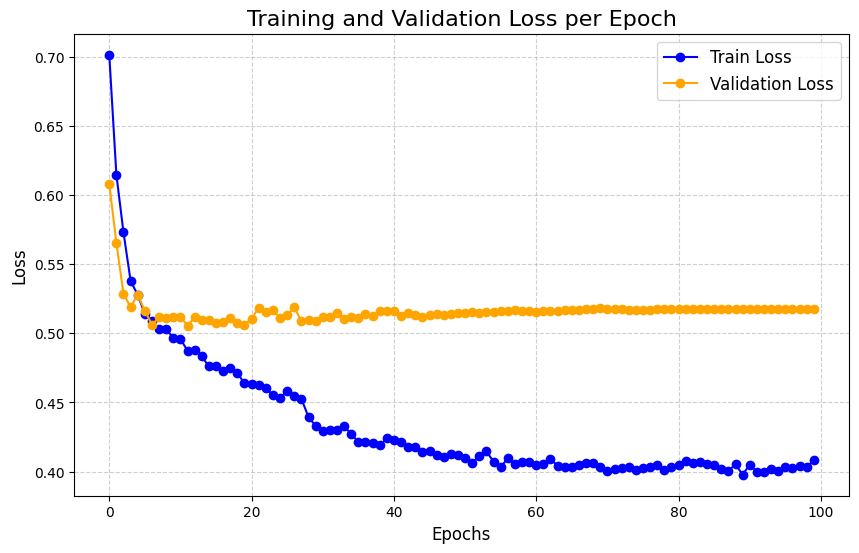

###########################Treinamento final concluído com sucesso!######################################
Menor perda de validação: 0.5055
###########################Avaliando no conjunto de teste!######################################
ROC AUC (Teste): 0.8555
Acurácia (Teste): 0.8480
Precisão (Teste): 0.6077
Recall (Teste): 0.6387
F1-Score (Teste): 0.6228


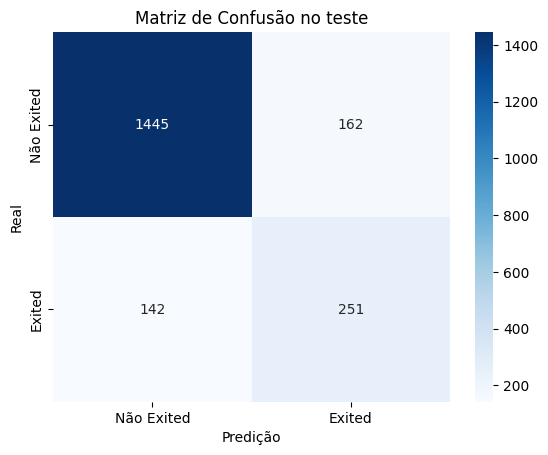

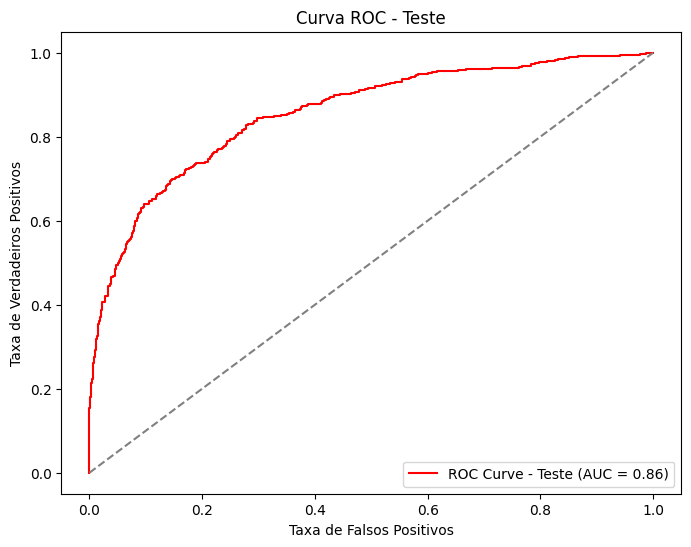

In [52]:

# Inicializando a barra de progresso
epochs = 100 #quantidade de epocas
bar = tqdm(total=epochs, desc="########### Treinamento final ##############", ncols=100, position=0)

X = X[selected_features] # variaveis com importancia determinada pelo randomforest

# Divisão dos dados 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Ajusta no treino
X_val = scaler.transform(X_val)   # Ajusta no validacao

# Convertendo para tensores 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# tensores de treinamento e validação
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Criando os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=4)




# Função de treinamento de uma época (modelo ja esta treinado)
def train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Clipping de gradientes para evitar explosão
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    
    return epoch_loss



# Função de validação
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    return val_loss / len(val_loader.dataset)



# Inicializando o modelo, otimizador e scheduler
model, criterion, optimizer, scheduler = create_model(**best_params)
model.to(device)  # (GPU ou CPU)



# armazenar as perdas em listas
train_losses = []
val_losses = []
best_loss = float('inf')

# Loop de treinamento final
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Ajuste do scheduler com a perda de validação, se aplicável
    if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)

    # Salvando o melhor modelo
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth") #aqui salva o OrderedDict (sopmente os parametros, bom pra usar no mesmo codigo enquanto treina e testa)
        torch.save(model, 'best_model_inteiro.pth') #salva o modelo INTEIRO com dict e tudo, bom para aplicar o modelo em producao
        torch.save(scaler, 'scaler.pth')  # Salvar scaler usado no treino


    bar.update(1)

bar.close()





# Carregar o melhor modelo após o treinamento
model.load_state_dict(torch.load("best_model.pth"))


# Plotando as perdas por época
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='-', marker='o')
plt.title('Training and Validation Loss per Epoch', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("###########################Treinamento final concluído com sucesso!######################################")
print(f"Menor perda de validação: {best_loss:.4f}")



# Avaliação final
print("###########################Avaliando no conjunto de teste!######################################")
# Carregando o melhor modelo
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


# Avaliando no conjunto de teste
with torch.no_grad():
    y_pred_logits = model(X_test_tensor.to(device)).cpu().numpy().squeeze()  # logits
    y_pred_prob_test = torch.sigmoid(torch.tensor(y_pred_logits)).cpu().numpy()  # Aplicando a sigmoide para obter probabilidades



#threshold 
# Fixando em 0.5
threshold = 0.5
y_pred_class_test = (y_pred_prob_test > threshold).astype(int)



# Calculando métricas e exibindo métricas
roc_auc = roc_auc_score(y_test, y_pred_prob_test)
accuracy = accuracy_score(y_test, y_pred_class_test)
precision = precision_score(y_test, y_pred_class_test)
recall = recall_score(y_test, y_pred_class_test)
f1 = f1_score(y_test, y_pred_class_test)
print(f"ROC AUC (Teste): {roc_auc:.4f}")
print(f"Acurácia (Teste): {accuracy:.4f}")
print(f"Precisão (Teste): {precision:.4f}")
print(f"Recall (Teste): {recall:.4f}")
print(f"F1-Score (Teste): {f1:.4f}")

#matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred_class_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Exited', 'Exited'], yticklabels=['Não Exited', 'Exited'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão no teste')
plt.show()

# Cálculo da curva ROC para o conjunto de teste
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)
# Gráfico ROC teste
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label=f'ROC Curve - Teste (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC - Teste')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


10. **Simulacao em producao:**
* Aplicado modelo na base inteira (foi o mais proximo de dados novos que pude testar); 

* Graficos de desempenho e matriz de confusao

################FAZENDO PREDIÇÕES SIMULANDO UMA APLICAÇÃO EM PRODUÇÃO EM DADOS NOVOS ##############################


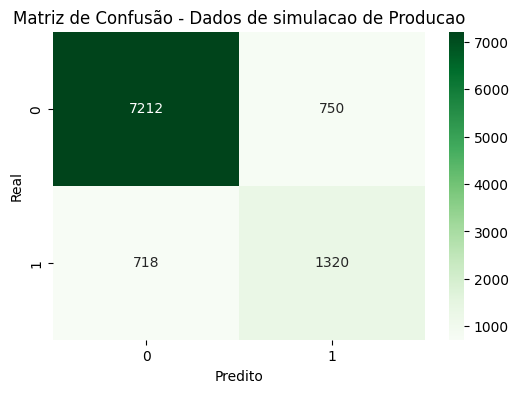

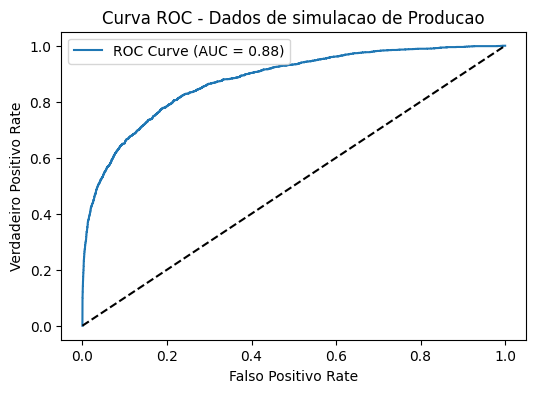

Acurácia total - Dados de simulacao de Producao: 85.32%
Recall da classe positiva - Dados de simulacao de Producao: 64.77%
📊 MÉTRICAS DO MODELO - SIMULA PRODUCAO
Métrica             Valor final    
------------------------------------------------------------
Acurácia            0.8532
Precisão            0.6377
Recall              0.6477
F1-Score            0.6426
AUC-ROC             0.8761
MCC                 0.5503
Acurácia Balanceada 0.7767
------------------------
Início: 2025-03-11 03:34:23.902018
Fim:    2025-03-11 07:15:16.244473
------------------------


In [53]:
print('################FAZENDO PREDIÇÕES SIMULANDO UMA APLICAÇÃO EM PRODUÇÃO EM DADOS NOVOS ##############################')

# Carregar o modelo treinado inteiro e em modo de avaliação
model = torch.load('best_model_inteiro.pth')
model.eval()

# Carregar o scaler 
scaler = torch.load('scaler.pth')

# Carregar os novos dados 
df_new = pd.concat([base_corrige_teste,teste_multco_treino], axis = 0)

# Selecionar fetures (geradas pelo randonforest)
#df_new = df_new.head(5000) # para testar em apenas 5000 observações
X_new = df_new[selected_features]  

# Separar as labels (y) e features (X)
y_true = df_new['Exited'].values  

# Normalizar
X_scaled = scaler.transform(X_new)

# tensor 
input_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# (GPU ou CPU) 
input_tensor = input_tensor.to(device)  

# Obter predições do modelo
with torch.no_grad():
    y_pred_logits = model(input_tensor)  # Logits 
    y_pred_prob = torch.sigmoid(y_pred_logits)  # sigmoide para obter probabilidades

# Converter para numpy (aqui nao da pra usar GPU, nao tem jeito)
y_pred_logits = y_pred_logits.cpu().numpy()
y_pred_prob = y_pred_prob.cpu().numpy()

# Converter probabilidades em classes (0 ou 1)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Calcular  e visualizar matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Dados de simulacao de Producao')
plt.show()

# Calcular e plotar curva ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de referência
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate')
plt.title('Curva ROC - Dados de simulacao de Producao')
plt.legend()
plt.show()

# Calcular a acurácia 
accuracy_positive = accuracy_score(y_true, y_pred_class)
print(f"Acurácia total - Dados de simulacao de Producao: {accuracy_positive * 100:.2f}%")

# Calcular o recall 
positive_class_recall = recall_score(y_true, y_pred_class)
print(f"Recall da classe positiva - Dados de simulacao de Producao: {positive_class_recall * 100:.2f}%")

# Métricas de avaliação de classificação
metrics = {
    "Acurácia": accuracy_score,
    "Precisão": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "AUC-ROC": roc_auc_score,
    "MCC": matthews_corrcoef,
    "Acurácia Balanceada": balanced_accuracy_score
}

metric_results = {}

for metric_name, metric_function in metrics.items():
    if metric_name == "AUC-ROC":
        score = metric_function(y_true, y_pred_prob)
    else:
        score = metric_function(y_true, y_pred_class)
    metric_results[metric_name] = score

# Printar métricas 
print("📊 MÉTRICAS DO MODELO - SIMULA PRODUCAO")
print("="*60)
print(f"{'Métrica':<20}{'Valor final':<15}")
print("-"*60)

for metric_name, score in metric_results.items():
    print(f"{metric_name:<20}{score:.4f}")

print("="*60)

# Fim
end_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print("Fim:   ", end_time_utc)
print('------------------------')


# Conclusao:

**Modelo treinado e testado com bons resultados preditivos, apesar de muitos falsos positivos, que podem ser um problema dependendo da ação a ser tomada com os resultados do modelo. Em cenários onde as ações para evitar o churn sejam caras, ou em cenários de comunicação onde há risco de importunação ao cliente ou algum tipo de aborrecimento que tenha o efeito contrário ao de evitar o churn, esses falsos positivos serão preocupantes. Há a possibilidade de alterar as métricas de maximização para aumentar esse equilíbrio entre verdadeiros positivos e falsos positivos. Ainda assim, o mais provável é que ainda se necessite da adição de variáveis que expliquem melhor o evento de churn e mais observações para melhorar a capacidade preditiva. Anteriormente a esse modelo, foram testados modelos de árvore, como CatBoost, XGBoost e regressão logística (nao e arvore); os resultados foram bem próximos, o que corrobora que sejam necessárias novas variáveis e observações que possam, de fato, melhorar o estudo nessa base de dados.** 

# **THE END** 